# Scikit-Learn Gradient Boosted Tree Feature Importance

This notebook explains how to generate feature importance plots from `scikit-learn` using tree-based feature importance, permutation importance and `shap`.

This notebook will build and evaluate a model to predict arrival delay for flights in and out of NYC in 2013.  

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce

from sklearn.ensemble import GradientBoostingRegressor

## Reading the data

The data is from `rdatasets` imported using the Python package `statsmodels`.

In [2]:
df = sm.datasets.get_rdataset('flights', 'nycflights13').data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

## Feature Engineering

### Handle null values

In [3]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

As this model will predict arrival delay, the `Null` values are caused by flights did were cancelled or diverted. These can be excluded from this analysis.

In [4]:
df.dropna(inplace=True)

### Convert the times from floats or ints to hour and minutes

In [5]:
df['arr_hour'] = df.arr_time.apply(lambda x: int(np.floor(x/100)))
df['arr_minute'] = df.arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_arr_hour'] = df.sched_arr_time.apply(lambda x: int(np.floor(x/100)))
df['sched_arr_minute'] = df.sched_arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_dep_hour'] = df.sched_dep_time.apply(lambda x: int(np.floor(x/100)))
df['sched_dep_minute'] = df.sched_dep_time.apply(lambda x: int(x - np.floor(x/100)*100))
df.rename(columns={'hour': 'dep_hour',
                   'minute': 'dep_minute'}, inplace=True)

## Prepare data for modeling

### Set up train-test split

In [6]:
target = 'arr_delay'
y = df[target]
X = df.drop(columns=[target, 'flight', 'tailnum', 'time_hour', 'year', 'dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'dep_delay'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1066)

### Encode categorical variables

We use a leave-one-out encoder as it creates a single column for each categorical variable instead of creating a column for each level of the categorical variable like one-hot-encoding.  This makes interpreting the impact of categorical variables with feature impact easier.

In [7]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train, y_train)
X_test_loo = encoder.transform(X_test)

## Fit the model

In [8]:
model = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
model.fit(X_train_loo, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_loo)))
rmse

43.000748477245494

## Feature Importance

### Plot the tree-based or gini importance

Text(0.5, 1.0, 'Feature Importance')

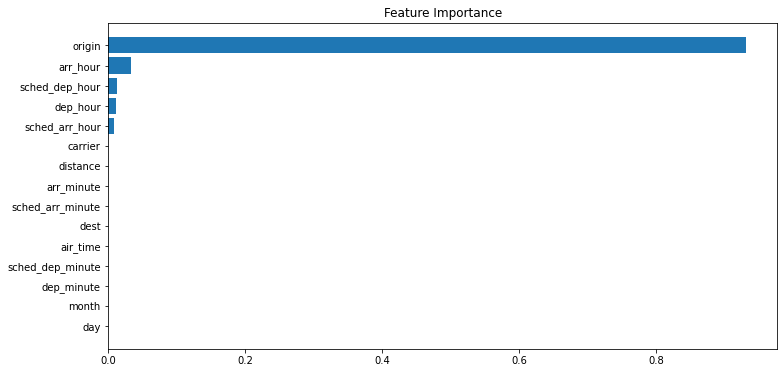

In [9]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Plot the permutation importance.

Text(0.5, 1.0, 'Permutation Importance')

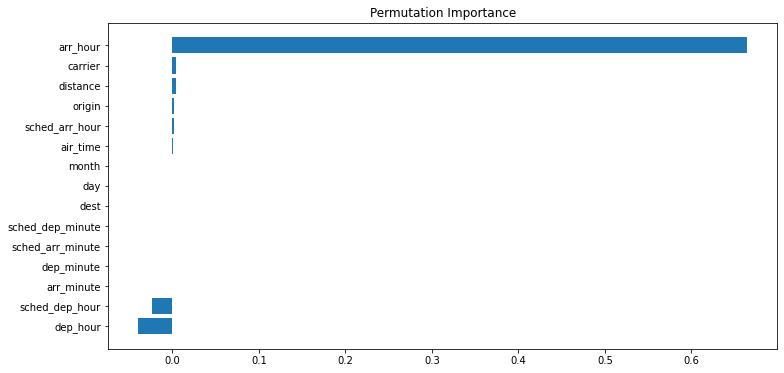

In [10]:
perm_importance = permutation_importance(model, X_test_loo, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

### Plot the mean absolute value of the SHAP values

Text(0.5, 1.0, 'SHAP Importance')

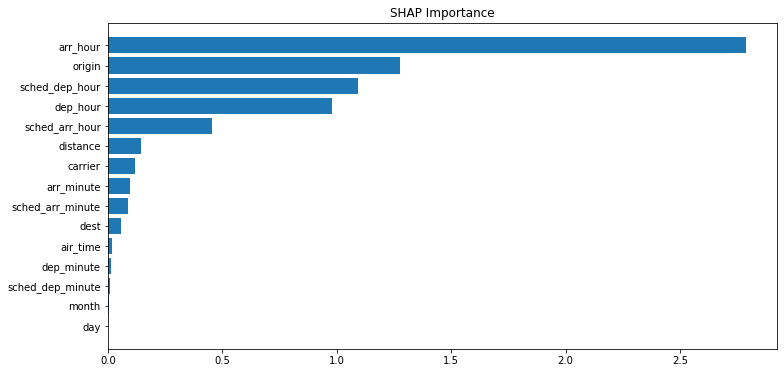

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test_loo)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

`SHAP` contains a function to plot this directly.

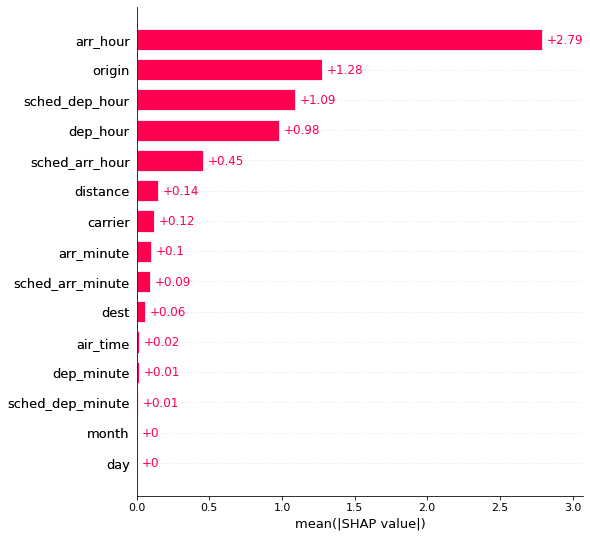

In [12]:
shap.plots.bar(shap_values, max_display=X_test_loo.shape[0])